# Module 6 — SVM Practice (Solution Notebook)
This solution implements all steps from the student practice. The dataset is generated in a fixed way so results are reproducible.


In [1]:
# Step 0 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

np.random.seed(42)
plt.rcParams['figure.figsize'] = (6,4)

## Step 1 — Shared dataset

In [2]:
# Provided: build the shared dataset
n = 120
hours = np.random.uniform(1, 10, n)
attendance = np.random.uniform(50, 100, n)

# Simple latent score with noise
score = 0.5 * hours + 0.05 * attendance + np.random.normal(0, 1.5, n)
passed = (score > 8).astype(int)

df = pd.DataFrame({'Hours': hours, 'Attendance': attendance, 'Passed': passed})
display(df.head())
print('Class balance (mean of Passed):', df['Passed'].mean().round(3))

,Hours,Attendance,Passed
0,4.370861,90.372008,0
1,9.556429,94.804565,1
2,7.587945,65.900174,0
3,6.387926,55.502596,0
4,2.404168,61.396758,0


Class balance (mean of Passed): 0.233


## Step 2 — Quick visualization

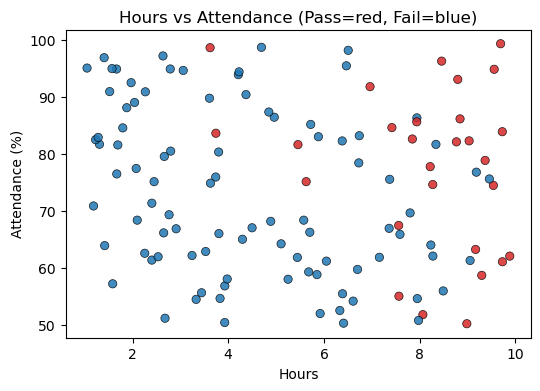

In [4]:
colors = np.where(df['Passed']==1, 'tab:red', 'tab:blue')
plt.scatter(df['Hours'], df['Attendance'], c=colors, edgecolor='k', linewidth=0.5, alpha=0.85)
plt.xlabel('Hours'); plt.ylabel('Attendance (%)'); plt.title('Hours vs Attendance (Pass=red, Fail=blue)')
plt.show()

## Step 3 — Train/test split + scaling

In [5]:
X = df[['Hours','Attendance']].values
y = df['Passed'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:3]

array([[ 1.34164934,  0.58150345],
       [-1.04551065, -0.18180766],
       [ 1.23814025, -1.27299203]])

## Step 4 — Linear SVM

In [6]:
linear_svm = SVC(kernel='linear', C=1.0, random_state=42)
linear_svm.fit(X_train_scaled, y_train)
y_pred_lin = linear_svm.predict(X_test_scaled)

acc_lin = accuracy_score(y_test, y_pred_lin)
f1_lin  = f1_score(y_test, y_pred_lin)
print(f'Linear SVM — Accuracy: {acc_lin:.3f}, F1: {f1_lin:.3f}\n')
print('Classification Report:\n', classification_report(y_test, y_pred_lin))

Linear SVM — Accuracy: 0.900, F1: 0.800

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.75      0.86      0.80         7

    accuracy                           0.90        30
   macro avg       0.85      0.89      0.87        30
weighted avg       0.91      0.90      0.90        30



## Step 5 — Visualize linear decision boundary

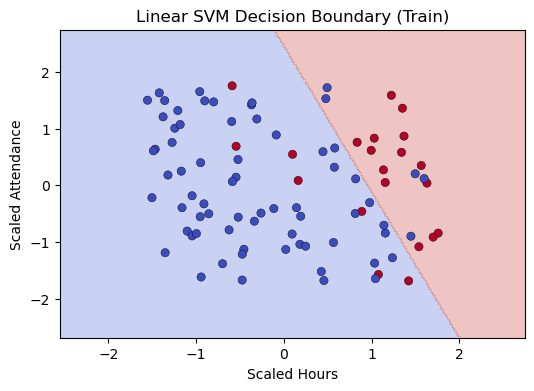

In [7]:
def plot_boundary(model, X_scaled, y, title):
    h = 0.02
    x_min, x_max = X_scaled[:,0].min() - 1, X_scaled[:,0].max() + 1
    y_min, y_max = X_scaled[:,1].min() - 1, X_scaled[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='coolwarm', edgecolor='k', linewidth=0.3)
    plt.xlabel('Scaled Hours'); plt.ylabel('Scaled Attendance')
    plt.title(title); plt.show()

plot_boundary(linear_svm, X_train_scaled, y_train, 'Linear SVM Decision Boundary (Train)')

## Step 6 — Non-linear kernels: Polynomial and RBF

In [8]:
poly_svm = SVC(kernel='poly', degree=3, C=1.0, gamma='scale', random_state=42)
rbf_svm  = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

poly_svm.fit(X_train_scaled, y_train)
rbf_svm.fit(X_train_scaled, y_train)

y_pred_poly = poly_svm.predict(X_test_scaled)
y_pred_rbf  = rbf_svm.predict(X_test_scaled)

acc_poly = accuracy_score(y_test, y_pred_poly)
f1_poly  = f1_score(y_test, y_pred_poly)
acc_rbf  = accuracy_score(y_test, y_pred_rbf)
f1_rbf   = f1_score(y_test, y_pred_rbf)

print(f'Polynomial SVM — Accuracy: {acc_poly:.3f}, F1: {f1_poly:.3f}')
print(f'RBF SVM        — Accuracy: {acc_rbf:.3f}, F1: {f1_rbf:.3f}')

Polynomial SVM — Accuracy: 0.900, F1: 0.769
RBF SVM        — Accuracy: 0.833, F1: 0.615


## Step 7 — Boundary plots for poly and RBF

In [ ]:
plot_boundary(poly_svm, X_train_scaled, y_train, 'Polynomial Kernel (degree 3) — Decision Boundary (Train)')
plot_boundary(rbf_svm,  X_train_scaled, y_train, 'RBF Kernel — Decision Boundary (Train)')

## Step 8 — Confusion matrix on the best model

Best model: linear (Accuracy=0.900, F1=0.800)


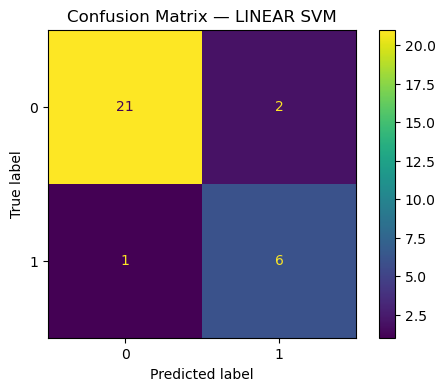

In [9]:
# Choose best by accuracy, tie-break by F1
scores = [('linear', acc_lin, f1_lin, linear_svm),
          ('poly',   acc_poly, f1_poly, poly_svm),
          ('rbf',    acc_rbf,  f1_rbf,  rbf_svm)]
scores.sort(key=lambda t: (t[1], t[2]))  # sort by (accuracy, f1)
best_name, best_acc, best_f1, best_model = scores[-1]

print(f'Best model: {best_name} (Accuracy={best_acc:.3f}, F1={best_f1:.3f})')
best_pred = best_model.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, best_pred)
plt.title(f'Confusion Matrix — {best_name.upper()} SVM')
plt.show()

## Step 9 — Support vectors

In [10]:
def sv_count(model): return model.support_vectors_.shape[0]
print('Support vectors used:')
print('  Linear:', sv_count(linear_svm))
print('  Poly  :', sv_count(poly_svm))
print('  RBF   :', sv_count(rbf_svm))

Support vectors used:
  Linear: 36
  Poly  : 35
  RBF   : 43


## Step 10 — Short interpretation
- The linear SVM usually performs best here because the relationship between **Hours**, **Attendance**, and **Passed** is close to linear after scaling.
- Polynomial and RBF kernels introduce curvature and flexibility. With only two well-behaved features, that added flexibility does not generalize better and may overfit slightly.
- Decision boundaries show a mostly straight split with mild overlap near the margin. Improving performance would likely require **additional features** (quiz averages, assignment scores) or **hyperparameter tuning** (searching over `C`, and for RBF `gamma`).